In [103]:
%pip install -q contextily folium mapclassify

Note: you may need to restart the kernel to use updated packages.


In [35]:
%%capture
%env AWS_ACCESS_KEY_ID=
%env AWS_SECRET_ACCESS_KEY=
%env AWS_SESSION_TOKEN=
%env AWS_REQUEST_PAYER=requester

In [2]:
from os.path import join, basename
from glob import glob
import gc

from rastervision.pipeline.file_system.utils import (
    file_exists, file_to_json, json_to_file, list_paths)
from rastervision.core.box import Box
from rastervision.core.data import (
    geoms_to_geojson, RasterioSource, RasterioCRSTransformer, Scene)
from rastervision.core.data.utils import (geoms_to_geojson)
from rastervision.core.data.raster_source.stac_config import subset_assets
from rastervision.pytorch_learner.dataset import (
    SemanticSegmentationSlidingWindowGeoDataset)

from tqdm.auto import tqdm, trange
import albumentations as A
import numpy as np
import torch
from torch.utils.data import ConcatDataset, DataLoader
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.reset_defaults()
import contextily as cx

import pystac_client
from pystac import ItemCollection
from shapely.geometry import mapping, shape, Point
import pandas as pd
import geopandas as gpd
import rasterio as rio

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.18 (you have 1.4.13). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


In [2]:
catalog = pystac_client.Client.open('https://earth-search.aws.element84.com/v1')

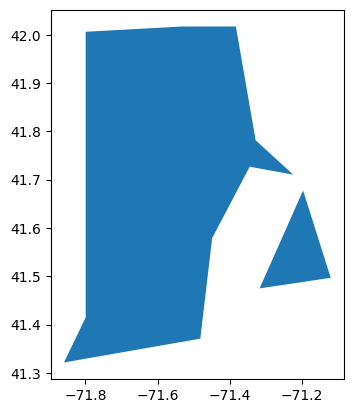

In [3]:
df = gpd.read_file('data/us-states.json')
df_aoi = df[df.name == 'Rhode Island']
df_aoi.plot()
plt.show()

In [4]:
aoi = df_aoi.geometry.unary_union.simplify(0)
aoi_name = 'RI'
year_old = 2018
year_new = 2021

In [169]:
items_old = catalog.search(
    intersects=mapping(aoi),
    collections=['naip'],
    datetime=f'{year_old}-01-01/{year_old + 1}-01-01',
).item_collection()
len(items_old)

140

In [183]:
items_new = catalog.search(
    intersects=mapping(aoi),
    collections=['naip'],
    datetime=f'{year_new}-01-01/{year_new + 1}-01-01',
).item_collection()
len(items_new)

141

In [5]:
items_path_new = f'data/stac_items_naip_{aoi_name}_{year_new}.json'
# json_to_file(items_new.to_dict(), items_path_new)
items_new = ItemCollection.from_file(items_path_new)

In [6]:
items_path_old = f'data/stac_items_naip_{aoi_name}_{year_old}.json'
# json_to_file(items_old.to_dict(), items_path_old)
items_old = ItemCollection.from_file(items_path_old)

In [7]:
df_items_old = gpd.GeoDataFrame.from_features(items_old)
df_items_old.loc[:, 'id'] = [item.id for item in items_old]
df_items_old.loc[:, 'uri'] = [item.assets['image'].href for item in items_old]
df_items_new = gpd.GeoDataFrame.from_features(items_new)
df_items_new.loc[:, 'id'] = [item.id for item in items_new]
df_items_new.loc[:, 'uri'] = [item.assets['image'].href for item in items_new]
len(df_items_old), len(df_items_new)

(140, 141)

In [8]:
df_items_old = df_items_old[df_items_old.id.str.startswith(aoi_name.lower())].copy()
df_items_new = df_items_new[df_items_new.id.str.startswith(aoi_name.lower())].copy()
df_items_old = df_items_old.drop_duplicates(['uri'])
df_items_new = df_items_new.drop_duplicates(['uri'])
len(df_items_old), len(df_items_new)

(104, 104)

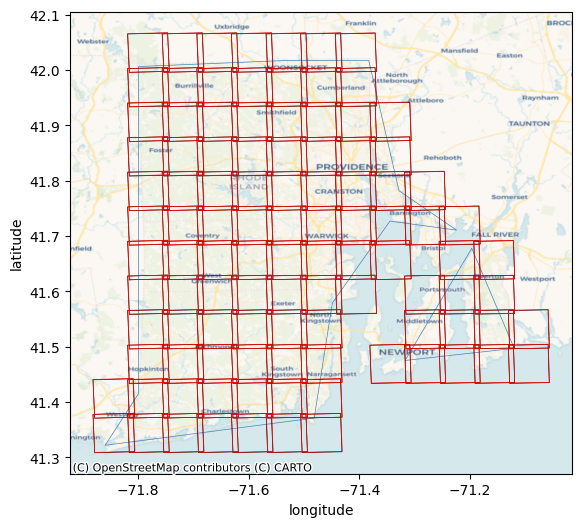

In [187]:
plt.close('all')
fig, ax = plt.subplots(figsize=(10, 6))
df_aoi.plot(ax=ax, ec='steelblue', fc='none', lw=0.5)
df_items_old.plot(ax=ax, ec='k', fc='none', lw=0.5)
df_items_new.plot(ax=ax, ec='r', fc='none', lw=0.5)
cx.add_basemap(ax, crs='epsg:4326', source=cx.providers.CartoDB.Voyager)
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
plt.show()

In [51]:
items_old[-1].assets['image'].href

's3://naip-analytic/ma/2018/60cm/rgbir_cog/42070/m_4207002_sw_19_060_20180806.tif'

In [49]:
items_new[-1]

<Item id=ma_m_4106909_se_19_060_20210826>

In [106]:
gpd.GeoDataFrame.explore?

Signature: gpd.GeoDataFrame.explore(self, *args, **kwargs)
Docstring:
Interactive map based on GeoPandas and folium/leaflet.js

Generate an interactive leaflet map based on :class:`~geopandas.GeoDataFrame`

Parameters
----------
column : str, np.array, pd.Series (default None)
    The name of the dataframe column, :class:`numpy.array`,
    or :class:`pandas.Series` to be plotted. If :class:`numpy.array` or
    :class:`pandas.Series` are used then it must have same length as dataframe.
cmap : str, matplotlib.Colormap, branca.colormap or function (default None)
    The name of a colormap recognized by ``matplotlib``, a list-like of colors,
    :class:`matplotlib.colors.Colormap`, a :class:`branca.colormap.ColorMap` or
    function that returns a named color or hex based on the column
    value, e.g.::

        def my_colormap(value):  # scalar value defined in 'column'
            if value > 1:
                return "green"
            return "red"

color : str, array-like (default None

In [134]:
df_items_new[df_items_new['grid:code'] == 'DOQQ-4207159SW'].uri.tolist()

['s3://naip-analytic/ma/2021/60cm/rgbir_cog/42071/m_4207159_sw_19_060_20210926.tif',
 's3://naip-analytic/ma/2021/60cm/rgbir_cog/42071/m_4207159_sw_19_060_20210926.tif']

In [129]:
df_items_new.groupby(['grid:code']).size().reset_index().sort_values(0, ascending=False)

,grid:code,0
364,DOQQ-4207159SW,2
360,DOQQ-4207158SW,2
359,DOQQ-4207158SE,2
547,DOQQ-4207257SE,2
356,DOQQ-4207157SW,2
...,...,...
222,DOQQ-4207124NW,1
223,DOQQ-4207124SE,1
224,DOQQ-4207124SW,1
225,DOQQ-4207125NE,1


In [59]:
from IPython.display import display, HTML

def wrap_df_text(df):
    return display(HTML(df.to_html().replace("\\n","<br>")))

In [118]:
tmp = pd.merge(df_items_old, df_items_new, on='grid:code', how='inner')[['uri_x', 'uri_y']]
tmp['uri_x'] = tmp['uri_x'].str.wrap(42)
tmp['uri_y'] = tmp['uri_y'].str.wrap(42)

In [120]:
len(tmp)

685

In [119]:
wrap_df_text(tmp[['uri_x', 'uri_y']])

,uri_x,uri_y
0,s3://naip-analytic/ma/2018/60cm/rgbir_cog/42072/m_4207258_nw_18_060_20181123.tif,s3://naip-analytic/ma/2021/60cm/rgbir_cog/42072/m_4207258_nw_18_060_20211106.tif
1,s3://naip-analytic/ma/2018/60cm/rgbir_cog/42072/m_4207250_sw_18_060_20181123.tif,s3://naip-analytic/ma/2021/60cm/rgbir_cog/42072/m_4207250_sw_18_060_20211106.tif
2,s3://naip-analytic/ma/2018/60cm/rgbir_cog/42072/m_4207250_nw_18_060_20181123.tif,s3://naip-analytic/ma/2021/60cm/rgbir_cog/42072/m_4207250_nw_18_060_20211106.tif
3,s3://naip-analytic/ma/2018/60cm/rgbir_cog/42072/m_4207242_sw_18_060_20181123.tif,s3://naip-analytic/ma/2021/60cm/rgbir_cog/42072/m_4207242_sw_18_060_20211106.tif
4,s3://naip-analytic/ma/2018/60cm/rgbir_cog/42072/m_4207234_sw_18_060_20181123.tif,s3://naip-analytic/ma/2021/60cm/rgbir_cog/42072/m_4207234_sw_18_060_20211106.tif
5,s3://naip-analytic/ma/2018/60cm/rgbir_cog/42072/m_4207227_sw_18_060_20181123.tif,s3://naip-analytic/ma/2021/60cm/rgbir_cog/42072/m_4207227_sw_18_060_20211106.tif
6,s3://naip-analytic/ma/2018/60cm/rgbir_cog/42072/m_4207227_nw_18_060_20181123.tif,s3://naip-analytic/ma/2021/60cm/rgbir_cog/42072/m_4207227_nw_18_060_20211106.tif
7,s3://naip-analytic/ma/2018/60cm/rgbir_cog/42072/m_4207226_sw_18_060_20181123.tif,s3://naip-analytic/ma/2021/60cm/rgbir_cog/42072/m_4207226_sw_18_060_20211106.tif
8,s3://naip-analytic/ma/2018/60cm/rgbir_cog/42072/m_4207226_se_18_060_20181123.tif,s3://naip-analytic/ma/2021/60cm/rgbir_cog/42072/m_4207226_se_18_060_20211106.tif
9,s3://naip-analytic/ma/2018/60cm/rgbir_cog/42072/m_4207226_ne_18_060_20181123.tif,s3://naip-analytic/ma/2021/60cm/rgbir_cog/42072/m_4207226_ne_18_060_20211106.tif


In [70]:
!aws s3 cp s3://naip-analytic/vt/2018/60cm/rgbir_cog/42072/m_4207220_ne_18_060_old1123.tif data/ --request-payer=requester
!aws s3 cp s3://naip-analytic/vt/2021/60cm/rgbir_cog/42072/m_4207220_ne_18_060_new1019.tif data/ --request-payer=requester

download: s3://naip-analytic/vt/2018/60cm/rgbir_cog/42072/m_4207220_ne_18_060_20181123.tif to data/m_4207220_ne_18_060_20181123.tif
download: s3://naip-analytic/vt/2021/60cm/rgbir_cog/42072/m_4207220_ne_18_060_20211019.tif to data/m_4207220_ne_18_060_20211019.tif


In [80]:
!aws s3 ls --request-payer=requester s3://naip-visualization/vt/2021/60cm/rgb/42072/m_4207220_ne_18_060_new1019.tif data/m_4207220_ne_18_060_new1019.tif

2023-03-01 18:09:31   58355284 m_4207220_ne_18_060_20211019.tif


In [ ]:
pd.merge(df_items_old, df_items_new, on='proj:bbox', how='inner')

In [81]:
from rastervision.core.data import XarraySource

In [ ]:
rs_old = XarraySource.from_stac(items_old[:10], allow_streaming=True, stackstac_args=dict(rescale=False, assets=['image']))

In [ ]:
crses_old = []
with tqdm(df_items_old.uri) as bar:
    for uri in bar:
        with rio.open(uri) as ds:
            crses_old.append(ds.crs)

In [93]:
set(crses_old)

{CRS.from_epsg(26918), CRS.from_epsg(26919)}

In [97]:
set(crses_old[:100])

{CRS.from_epsg(26918), CRS.from_epsg(26919)}

In [188]:
tmp = pd.merge(df_items_old, df_items_new, on='grid:code', how='inner')
len(tmp)

104

In [189]:
tmp.loc[:, 'intersection'] = tmp.geometry_x.intersection(tmp.geometry_y).area
tmp.loc[:, 'iou'] = tmp['intersection'] / tmp.geometry_x.union(tmp.geometry_y).area
tmp.loc[:, 'ioa_x'] = tmp['intersection'] / tmp.geometry_x.area
tmp.loc[:, 'ioa_y'] = tmp['intersection'] / tmp.geometry_y.area

In [190]:
tmp[['id_x', 'id_y', 'grid:code', 'iou', 'ioa_x', 'ioa_y']].sort_values('ioa_x')

,id_x,id_y,grid:code,iou,ioa_x,ioa_y
20,ri_m_4107118_ne_19_060_20180930_20181211,ri_m_4107118_ne_19_060_20210926,DOQQ-4107118NE,0.985216,0.985217,0.999999
91,ri_m_4107127_ne_19_060_20180816_20181211,ri_m_4107127_ne_19_060_20210926,DOQQ-4107127NE,0.985216,0.985220,0.999995
50,ri_m_4107131_ne_19_060_20180827_20181211,ri_m_4107131_ne_19_060_20210826,DOQQ-4107131NE,0.985232,0.985233,0.999999
32,ri_m_4107105_ne_19_060_20180930_20181211,ri_m_4107105_ne_19_060_20210826,DOQQ-4107105NE,0.985234,0.985235,0.999999
95,ri_m_4107120_ne_19_060_20180816_20181211,ri_m_4107120_ne_19_060_20210826,DOQQ-4107120NE,0.985238,0.985238,1.000000
...,...,...,...,...,...,...
21,ri_m_4107113_sw_19_060_20180930_20181211,ri_m_4107113_sw_19_060_20210826,DOQQ-4107113SW,0.985513,0.999903,0.985607
0,ri_m_4207161_sw_19_060_20180930_20181211,ri_m_4207161_sw_19_060_20210826,DOQQ-4207161SW,0.985577,0.999904,0.985670
47,ri_m_4107131_sw_19_060_20180827_20181211,ri_m_4107131_sw_19_060_20210826,DOQQ-4107131SW,0.985575,0.999905,0.985667
75,ri_m_4207159_sw_19_060_20180816_20181211,ri_m_4207159_sw_19_060_20211019,DOQQ-4207159SW,0.985607,0.999905,0.985699


In [10]:
# !gdalwarp \
# -t_srs "EPSG:26918" \
# -of VRT "/vsis3/raster-vision-ahassan/naip/2018_MA/m_4207220_ne_18_060_20181123.tif" \
# "data/m_4207220_ne_18_060_20181123_crs26918.vrt"

In [11]:
# !gdalbuildvrt test.vrt "/vsis3/naip-analytic/ri/2018/60cm/rgbir_cog/42071/m_4207161_sw_19_060_20180930.tif"

In [24]:
# !mkdir data/tmp_old
!mkdir data/tmp_new

In [3]:
# rs_old = RasterioSource(df_items_old.uri.tolist(), allow_streaming=True, tmp_dir='data/tmp_old/')
rs_old = RasterioSource('data/tmp_old/index.vrt')
rs_old.shape

INFO:botocore.credentials:Found credentials in environment variables.


(141383, 115465, 3)

In [4]:
# rs_new = RasterioSource(df_items_new.uri.tolist(), allow_streaming=True, tmp_dir='data/tmp_new/')
rs_new = RasterioSource('data/tmp_new/index.vrt')
rs_new.shape

INFO:botocore.credentials:Found credentials in environment variables.


(141381, 115533, 4)

In [5]:
bbox_old_map = rs_old.crs_transformer.pixel_to_map(rs_old.bbox)
bbox_new_map = rs_new.crs_transformer.pixel_to_map(rs_new.bbox)
bbox_intersection_map = Box.from_shapely(bbox_old_map.to_shapely().intersection(bbox_new_map.to_shapely()))
bbox_intersection_pixel_old = rs_old.crs_transformer.map_to_pixel(bbox_intersection_map).normalize()
bbox_intersection_pixel_new = rs_new.crs_transformer.map_to_pixel(bbox_intersection_map).normalize()

In [61]:
mapping(bbox_old_map.to_shapely().intersection(bbox_new_map.to_shapely()))['coordinates'][0]

((-71.0511579682806, 42.062711453388026),
 (-71.0511579682806, 41.31782760601769),
 (-71.91224110422583, 41.31782760601769),
 (-71.91224110422583, 42.062711453388026),
 (-71.0511579682806, 42.062711453388026))

In [6]:
bbox_old_map, bbox_new_map

(Box(ymin=42.062711453388026, xmin=-71.91224810581886, ymax=41.31732690460382, xmax=-71.0511579682806),
 Box(ymin=42.06319251749325, xmin=-71.91224110422583, ymax=41.31782760601769, xmax=-71.05065756330595))

In [7]:
bbox_intersection_map

Box(ymin=42.062711453388026, xmin=-71.91224110422583, ymax=41.31782760601769, xmax=-71.0511579682806)

In [8]:
bbox_intersection_pixel_old, bbox_intersection_pixel_new

(Box(ymin=0, xmin=1, ymax=141290, xmax=115467),
 Box(ymin=89, xmin=-3, ymax=141379, xmax=115463))

In [10]:
rs_old.set_bbox(bbox_intersection_pixel_old)
rs_new.set_bbox(bbox_intersection_pixel_new)

In [34]:
rs_old.crs_transformer.pixel_to_map(Box(50_000, 50_000, 50_400, 50_400))

Box(ymin=41.80140150902098, xmin=-71.53930074410266, ymax=41.79930575648225, xmax=-71.53632939984371)

In [21]:
chip_old = rs_old[52_000:52_400, 51_000:51_400]
chip_new = rs_new[52_000:52_400, 51_000:51_400]

INFO:botocore.credentials:Found credentials in environment variables.
INFO:botocore.credentials:Found credentials in environment variables.


In [46]:
rs_new.crs_transformer.map_to_pixel(w, rs_new.bbox).to_global_coords(rs_new.bbox)

Box(ymin=50089, xmin=49996, ymax=50489, xmax=50396)

In [14]:
w = Box(ymin=41.80140150902098, xmin=-71.53930074410266, ymax=41.79930575648225, xmax=-71.53632939984371)
chip_old = rs_old.get_chip_by_map_window(w)
chip_new = rs_new.get_chip_by_map_window(w)

INFO:botocore.credentials:Found credentials in environment variables.
INFO:botocore.credentials:Found credentials in environment variables.


In [12]:
rs_old.crs_transformer.map_to_pixel(w).normalize(), rs_new.crs_transformer.map_to_pixel(w).normalize()

(Box(ymin=50000, xmin=50000, ymax=50400, xmax=50400),
 Box(ymin=50089, xmin=49996, ymax=50489, xmax=50396))

In [28]:
mu_old = chip_old.reshape(-1, 3).mean(axis=0)
sigma_old = chip_old.reshape(-1, 3).std(axis=0)
mu_new = chip_new[..., :3].reshape(-1, 3).mean(axis=0)
sigma_new = chip_new[..., :3].reshape(-1, 3).std(axis=0)

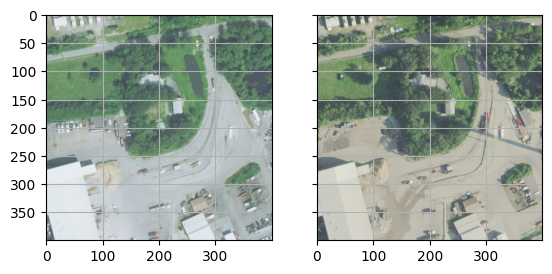

In [15]:
fig, (ax_old, ax_new) = plt.subplots(1, 2, sharex=True, sharey=True)
ax_old.imshow(chip_old[..., :3])
ax_new.imshow(chip_new[..., :3])
# ax_old.axis('off')
# ax_new.axis('off')
ax_old.grid()
ax_new.grid()
plt.show()

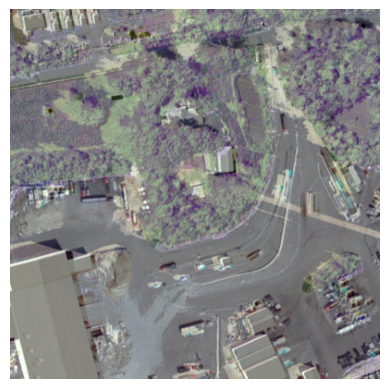

In [34]:
z_old = ((chip_new[..., :3] - mu_new[None, None]) / sigma_new)
z_new = ((chip_old - mu_old[None, None]) / sigma_old)
diff = (np.clip(z_new - z_old, -3, 3) + 3) / 6
plt.imshow(diff, cmap='gray')
plt.axis('off')
plt.show()

In [192]:
!aws s3 ls s3://raster-vision-ahassan/naip/2018_MA/

12250.25s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


2024-02-29 15:13:30  557975653 m_4207220_ne_18_060_20181123.tif
